# FlyHomes Data Challenge: Kaggle Zillow Prize
### Brian Henn - September 2018 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

In [2]:
# define filename and paths
fname_features_2016 = './data/properties_2016.csv'
fname_features_2017 = './data/properties_2017.csv'
fname_sales_2016 = './data/train_2016_v2.csv'
fname_sales_2017 = './data/train_2017.csv'
fname_sub = './data/sample_submission.csv'

In [3]:
# load 2016 and 2017 sales data
sales_2016 = pd.read_csv(fname_sales_2016, index_col=0, header=0, 
                         parse_dates=[2], infer_datetime_format=True)
sales_2017 = pd.read_csv(fname_sales_2017, index_col=0, header=0, 
                         parse_dates=[2], infer_datetime_format=True)
sales = pd.concat([sales_2016, sales_2017])
sales_set = sales.index.unique().values
print(sales.head(5))

          logerror transactiondate
parcelid                          
11016594    0.0276      2016-01-01
14366692   -0.1684      2016-01-01
12098116   -0.0040      2016-01-01
12643413    0.0218      2016-01-02
14432541   -0.0050      2016-01-02


In [4]:
# inner join 2016 and 2017 feature data with sales data on parcel id

# first, load 2016 feature data, grabbing only the rows with sales data for memory purposes
iter_csv = pd.read_csv(fname_features_2016, index_col=0, header=0, iterator=True, chunksize=50000)
features_2016 = pd.concat([chunk[chunk.index.isin(sales_set)] for chunk in iter_csv])

# now, join the feature data to the sales data, duplicating properties with multiple sales
features_2016_with_sales = features_2016.merge(sales, left_index=True, right_index=True)

/home/brian/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/brian/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/brian/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (22,49) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/brian/anaconda3/envs/insight/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Fraction of rows with at least one missing value: 1.0000.



Text(0.5,1,'Fraction of Missing Data')

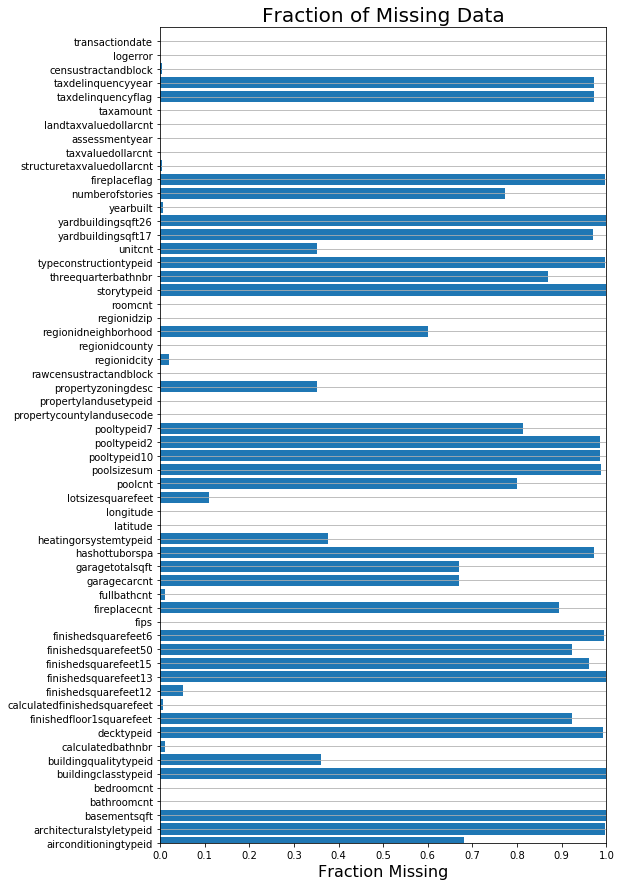

In [5]:
frac_at_least_one_missing = sum(features_2016_with_sales.isnull().sum(1) > 0)/len(features_2016_with_sales)
print('Fraction of rows with at least one missing value: %0.4f.\n' % (frac_at_least_one_missing))

frac_missing = []
for col in features_2016_with_sales.columns.values:
    frac_missing.append((len(features_2016_with_sales[col]) - features_2016_with_sales[col].count())/len(
        features_2016_with_sales[col]))
    
fig = plt.figure()
fig.set_size_inches([8,15])
ax = fig.subplots()
ax.barh(range(len(frac_missing)), frac_missing)
ax.set_xlim([0,1]) 
ax.set_xlabel('Fraction Missing', fontsize=16)
ax.set_ylim([0,len(frac_missing)])
ax.set_xticks(np.arange(0,1.01,0.1))
ax.set_yticks(range(len(frac_missing)))
ax.set_yticklabels(features_2016_with_sales.columns.values,rotation = 0);
ax.grid(True,'major','y')
ax.set_title('Fraction of Missing Data', fontsize=20)

In [6]:
# reduce features to those with at least 50% of data

features_2016_with_sales = features_2016_with_sales.iloc[:,[frac < 0.25 for frac in frac_missing]]
frac_missing = [frac_missing[i] for i, _ in enumerate(frac_missing) if frac_missing[i] < 0.25]

NameError: name 'a' is not defined

In [7]:
print(features_2016_with_sales.shape)
print(features_2016_with_sales.columns)

(167888, 26)
Index(['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'logerror', 'transactiondate'],
      dtype='object')
